In [7]:
import pandas as pd
import numpy as np
from vivarium import Artifact
import os
from pathlib import Path
from db_queries import get_outputs, get_ids, get_model_results, get_population
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gbd_mapping
from matplotlib.backends.backend_pdf import PdfPages
pd.set_option('use_inf_as_na', True)
sns.set(context = 'paper', style='whitegrid', font_scale=1.8, rc = {'axes.spines.right':False, 'axes.spines.top': False, 'figure.figsize':(12.7,8.6)}, palette='Set1')


## Change variable save_path to local directory file path for file results

In [6]:
mapping_dict_data = {'cause': {'acute_myocardial_infarction':'ischemic_heart_disease','post_myocardial_infarction':'ischemic_heart_disease','acute_ischemic_stroke':'ischemic_stroke','post_ischemic_stroke':'ischemic_stroke', 'other_causes':'other_causes', 'albuminuria':'chronic_kidney_disease', 'stage_iii_chronic_kidney_disease':'chronic_kidney_disease','stage_iv_chronic_kidney_disease':'chronic_kidney_disease','stage_v_chronic_kidney_disease':'chronic_kidney_disease','moderate_diabetes_mellitus':'diabetes_mellitus','severe_diabetes_mellitus':'diabetes_mellitus', 'chronic_kidney_disease':'chronic_kidney_disease'},
                    'sequela':{378:'acute_myocardial_infarction', 379:'acute_myocardial_infarction',380:'post_myocardial_infarction', 381:'post_myocardial_infarction', 382:'post_myocardial_infarction', 383:'post_myocardial_infarction', 384:'post_myocardial_infarction', 385:'post_myocardial_infarction', 953:'post_myocardial_infarction', 1040:'post_myocardial_infarction', 5726:'post_myocardial_infarction', 386: 'acute_ischemic_stroke', 387: 'acute_ischemic_stroke', 388: 'acute_ischemic_stroke', 389: 'acute_ischemic_stroke', 390: 'acute_ischemic_stroke', 391:'post_ischemic_stroke', 392: 'post_ischemic_stroke', 393:'post_ischemic_stroke', 394:'post_ischemic_stroke', 395:'post_ischemic_stroke', 946:'post_ischemic_stroke'},
                    'location': {'china':'China', 'brazil':'Brazil', 'france':'France', 'italy':'Italy', 'russian_federation':'Russian Federation', 'spain':'Spain'},
                    'sex':{'female':'Female','male':'Male'},
                    'measure':{'death':'deaths','ylds':'ylds','ylls':'ylls'},
                    'model_4_results':{'brazil':'brazil/2020_03_25_22_41_53','china':'china/2020_03_22_19_26_03', 'france':'france/2020_03_22_19_24_38', 'italy':'italy/2020_03_22_21_17_46', 'russian_federation':'russian_federation/2020_03_22_22_01_36', 'spain':'spain/2020_03_22_23_17_15'},
                    'model_5_results':{'brazil':'brazil/2020_03_29_23_20_34','china':'china/2020_03_29_23_20_41', 'france':'france/2020_03_29_23_20_52', 'italy':'italy/2020_03_29_23_20_47', 'spain':'spain/2020_03_29_23_20_51'}}

locations_model_4 = 'brazil'
locations = ['brazil','china','france','italy', 'russian_federation','spain']
measures = ['deaths', 'person_time','population','ylds','ylls']
save_path_j = '/home/j/Project/simulation_science/zenon/validation/model_5'

In [39]:
mapping_dict_data

{'cause': {'acute_myocardial_infarction': 'ischemic_heart_disease',
  'post_myocardial_infarction': 'ischemic_heart_disease',
  'acute_ischemic_stroke': 'ischemic_stroke',
  'post_ischemic_stroke': 'ischemic_stroke',
  'other_causes': 'other_causes',
  'albuminuria': 'chronic_kidney_disease',
  'stage_iii_chronic_kidney_disease': 'chronic_kidney_disease',
  'stage_iv_chronic_kidney_disease': 'chronic_kidney_disease',
  'stage_v_chronic_kidney_disease': 'chronic_kidney_disease',
  'moderate_diabetes_mellitus': 'diabetes_mellitus',
  'severe_diabetes_mellitus': 'diabetes_mellitus',
  'chronic_kidney_disease': 'chronic_kidney_disease'},
 'sequela': {378: 'acute_myocardial_infarction',
  379: 'acute_myocardial_infarction',
  380: 'post_myocardial_infarction',
  381: 'post_myocardial_infarction',
  382: 'post_myocardial_infarction',
  383: 'post_myocardial_infarction',
  384: 'post_myocardial_infarction',
  385: 'post_myocardial_infarction',
  953: 'post_myocardial_infarction',
  1040: 'pos

## Artifact 

* Pulled to compare against sim initialization and against GBD 2017

* EMR


In [40]:
def load_artifact_data_emr(locations):
    master_art_data = pd.DataFrame()
    for location in locations:
        for sequela in ['acute_myocardial_infarction', 'post_myocardial_infarction', 'acute_ischemic_stroke', 'post_ischemic_stroke']:
            art = Artifact(f'/share/costeffectiveness/artifacts/vivarium_csu_zenon/{location}.hdf', filter_terms=['year_start ==2017', 'age_start > 29'])
            data = art.load(f'sequela.{sequela}.excess_mortality_rate')

            data = pd.DataFrame(data.mean(axis=1)).reset_index().rename(columns={0:'value'})
            data['location'] = f'{location}'
            data['measure'] = 'excess_mortality_rate'
            data['age_group'] = 0
            data['cause'] = f'{sequela}'
            data['age_group'] = np.where(data['age_start'] == 30.0, '30_to_34', 
                                         np.where(data['age_start'] == 35.0, '35_to_39',
                                                  np.where(data['age_start'] == 40.0, '40_to_44',
                                                          np.where(data['age_start'] == 45.0, '45_to_49',
                                                                  np.where(data['age_start'] == 50.0, '50_to_54',
                                                                           np.where(data['age_start'] == 55.0, '55_to_59',
                                                                                   np.where(data['age_start'] == 60.0, '60_to_64',
                                                                                            np.where(data['age_start'] == 65.0, '65_to_69',
                                                                                                     np.where(data['age_start'] == 70.0, '70_to_74',
                                                                                                              np.where(data['age_start'] == 75.0, '75_to_79',
                                                                                                                       np.where(data['age_start'] == 80.0, '80_to_84',
                                                                                                                               np.where(data['age_start'] == 85.0, '85_to_89',
                                                                                                                                       np.where(data['age_start'] == 90.0, '90_to_94',
                                                                                                                                                np.where(data['age_start'] == 95.0, '95_plus', 'too_young'))))))))))))))
            master_art_data = master_art_data.append(data)
    master_art_data['year'] = '2017'

    master_art_data = master_art_data.drop(columns=['year_start', 'year_end', 'age_start', 'age_end'])
    master_art_data = master_art_data.set_index(['cause', 'measure', 'sex', 'age_group', ]).sort_index().reset_index()
    master_art_data[['value']] *= 100_000

    return master_art_data

In [41]:
artifact_emr = load_artifact_data_emr(locations)

### Model 5 outputs

In [ ]:
path_template = Path('/share/costeffectiveness/results/vivarium_csu_zenon/v5.0_correlated_risks_temp')

def get_model_outputs_sequela(locations, measure):
    outcomes = pd.DataFrame([])
    try:   
    
        for location in locations:

            if location == 'russian_federation':
                outcome = pd.read_hdf(f'/share/costeffectiveness/results/vivarium_csu_zenon/v5.0_correlated_risks/russian_federation/2020_03_30_15_01_53/count_data/{measure}.hdf')
            else:   
                country_loc = mapping_dict_data['model_5_results'][location]
                outcome = pd.read_hdf(str(path_template / f'{country_loc}/count_data/{measure}.hdf'))
            outcome['location'] = f'{location}'
            if measure != 'transition_count':
                outcome['measure'] = f'{measure}'
            outcomes = outcomes.append(outcome)
        return outcomes
            
    except:
            print(f'{measure} is not a measure in the outputs')

def get_model_outputs_cause(locations, measure):
    outcomes = pd.DataFrame([])
    try:   
    
        for location in locations:

            if location == 'russian_federation':
                outcome = pd.read_hdf(f'/share/costeffectiveness/results/vivarium_csu_zenon/v5.0_correlated_risks/russian_federation/2020_03_30_15_01_53/count_data/{measure}.hdf')
            else:   
                country_loc = mapping_dict_data['model_5_results'][location]
                outcome = pd.read_hdf(str(path_template / f'{country_loc}/count_data/{measure}.hdf'))
            outcome['location'] = f'{location}'
            if measure != 'transition_count':
                outcome['measure'] = f'{measure}'
            outcomes = outcomes.append(outcome)
        outcomes['cause'] = outcomes.cause.map(mapping_dict_data['cause'])
        outcomes = outcomes.groupby(['age_group','sex','year','cause','input_draw','location']).value.sum().reset_index()

        return outcomes
            
    except:
            print(f'{measure} is not a measure in the outputs')

In [ ]:
deaths = get_model_outputs_sequela(locations, 'deaths')
state = get_model_outputs_sequela(locations, 'state_person_time')

def get_emr(locations, deaths, state):
    
    index_columns = ['age_group', 'sex', 'year', 'input_draw','location', 'cause']
    deaths['measure'] = 'deaths'
    deaths = deaths[((deaths.cause == 'acute_myocardial_infarction') | (deaths.cause == 'post_myocardial_infarction') | (deaths.cause == 'acute_ischemic_stroke') | (deaths.cause == 'post_ishemic_stroke'))& (deaths.year == '2020')]
    state['measure'] = 'state'
    state = state[((state.cause == 'acute_myocardial_infarction') | (state.cause == 'post_myocardial_infarction') |  (state.cause == 'acute_ischemic_stroke') | (state.cause == 'post_ischemic_stroke')) & (state.year == '2020')]
    deaths  = deaths.set_index(index_columns).value
    state = state.set_index(index_columns).value
    rates = deaths / state * 100_000
    rates = rates.reset_index()
    rates['value'] = rates['value'].fillna(0)
    rates['measure'] = 'excess_mortality_rate'
    rates['sex'] = rates.sex.map(mapping_dict_data['sex'])
    return rates


In [46]:
emr = get_emr(locations, deaths, state)

### Compare Zenon Model vs. Data Artifact

* EMR for IHD disease states (acute MI, post MI)

In [100]:
def plot_results_compare_artifact_model(artifact_emr, locations, emr):

    cause_names = ['acute_myocardial_infarction', 'post_myocardial_infarction', 'acute_ischemic_stroke', 'post_ischemic_stroke']
    
    for cause in cause_names:
        with PdfPages(f'/home/j/Project/simulation_science/zenon/validation/model_5/model_compare_artifact/{cause}_artifact_compare_model.pdf') as pdf:        
            for sex in ['Male', 'Female']:
                for measure in ['excess_mortality_rate']:
                    for location in locations:
                        
                            data_g = emr[(emr.cause == cause) & (emr.sex == sex) & (emr.measure == measure) & (emr.location == location)]
                            data_m =data_g.groupby(['age_group']).value.mean().reset_index()
                            data_art = artifact_emr[(artifact_emr.cause == cause) & (artifact_emr.sex == sex) & (artifact_emr.measure == measure) & (artifact_emr.location == location)]

                            fig,ax = plt.subplots(1,1)

                            g = sns.lineplot(x='age_group', y='value',
                                            color='red', linewidth=4, ax=ax, alpha=0.2,
                                            data=data_art)
                            sns.lineplot(x='age_group', y='value',
                                         color='blue', linewidth=4, alpha=0.4, legend=False, ax=ax, 
                                          data=data_m)

                            g.set_title(f'{cause} {measure} in {location}, {sex}')
                            plt.xticks(rotation=70)
                            g.set_xlabel('Age group')
                            g.set_ylabel(f'{measure} per 100k person-years')

                            pdf.savefig(fig, orientation = 'landscape', bbox_inches='tight')

                            plt.show()
                            plt.clf() 


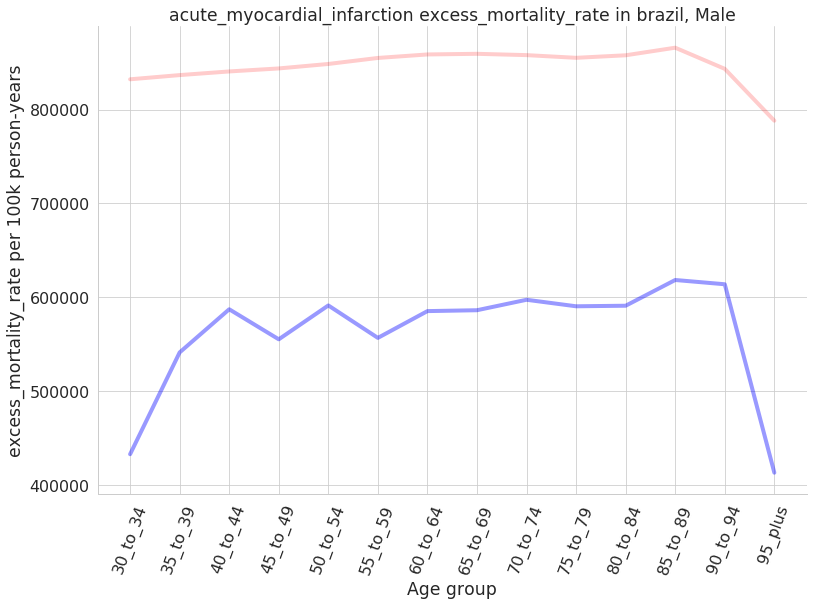

<Figure size 914.4x619.2 with 0 Axes>

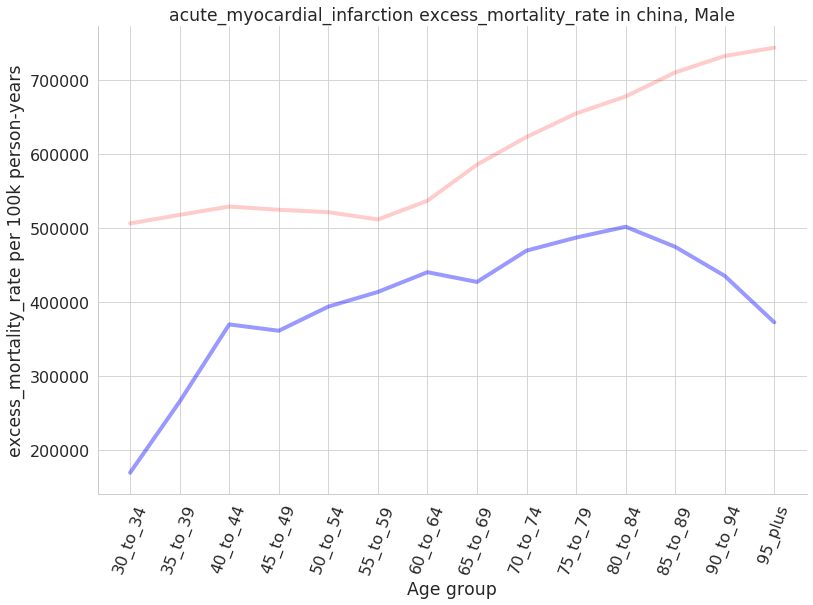

<Figure size 914.4x619.2 with 0 Axes>

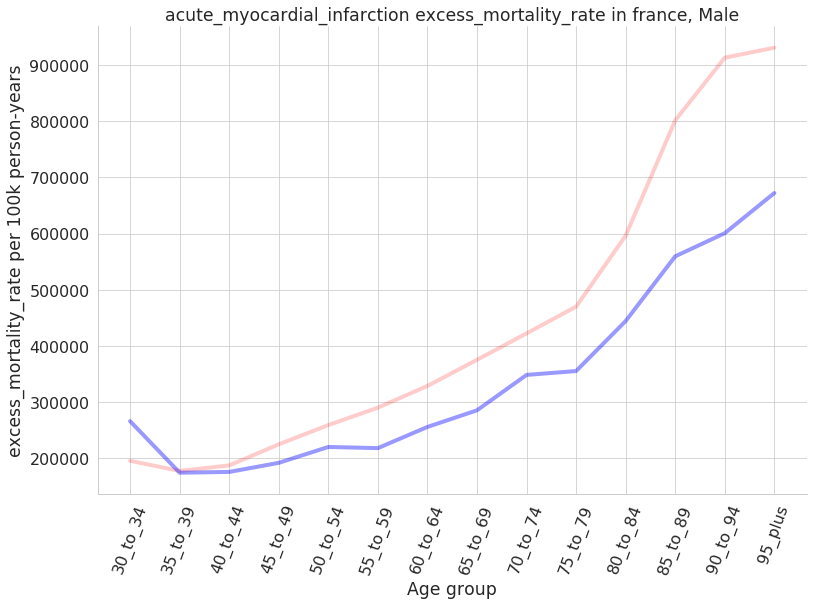

<Figure size 914.4x619.2 with 0 Axes>

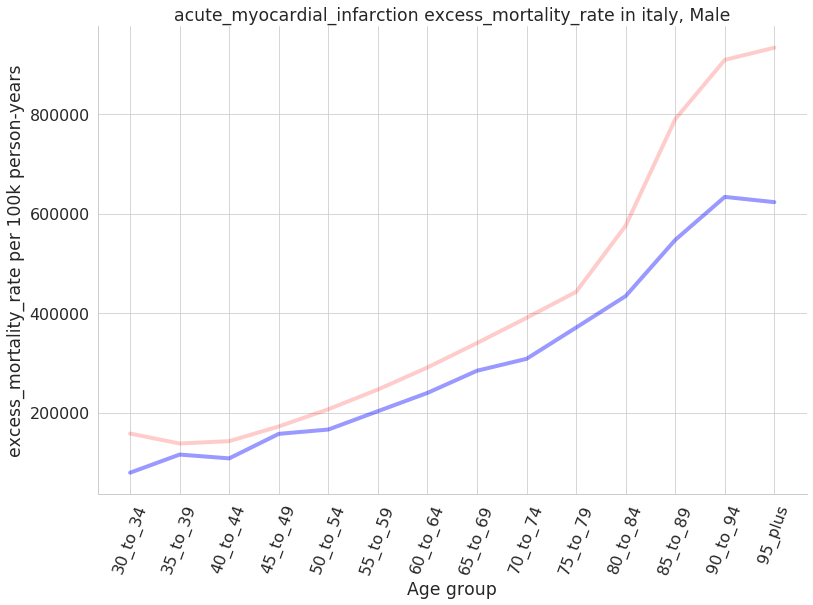

<Figure size 914.4x619.2 with 0 Axes>

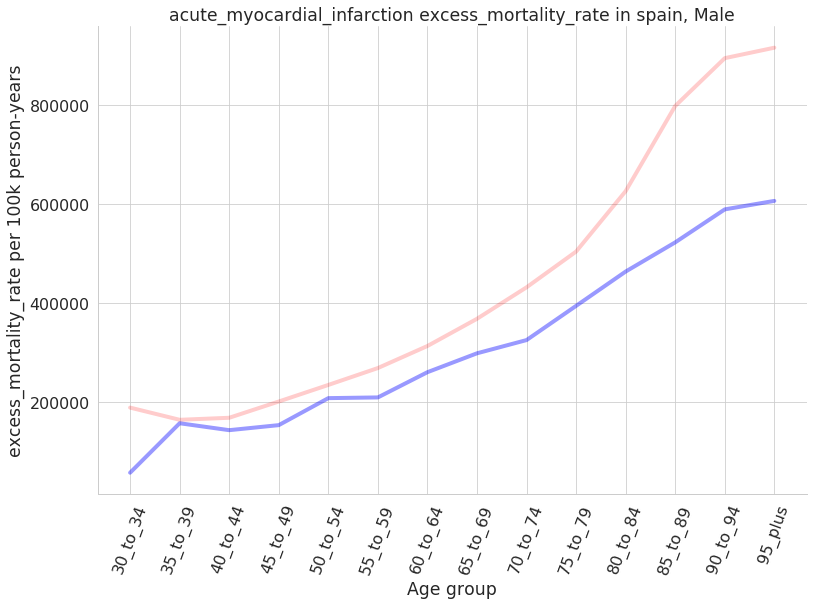

<Figure size 914.4x619.2 with 0 Axes>

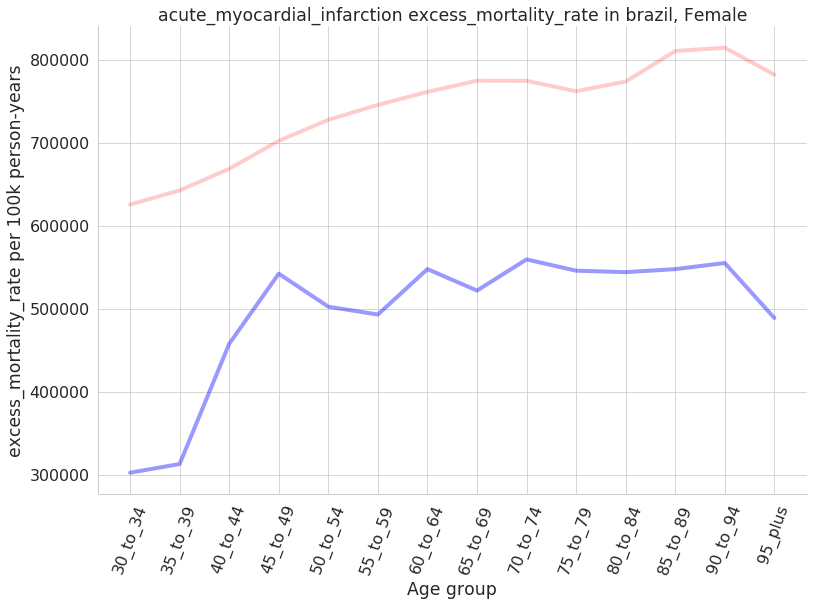

<Figure size 914.4x619.2 with 0 Axes>

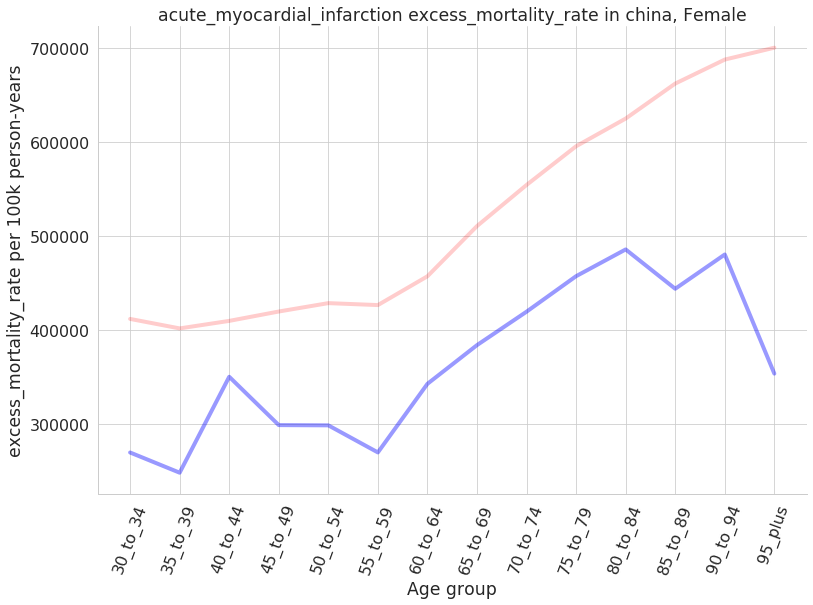

<Figure size 914.4x619.2 with 0 Axes>

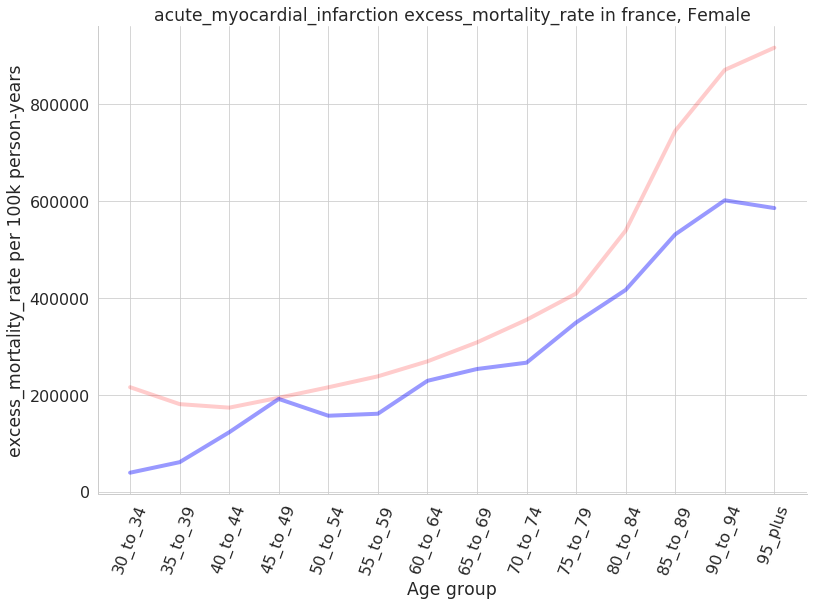

<Figure size 914.4x619.2 with 0 Axes>

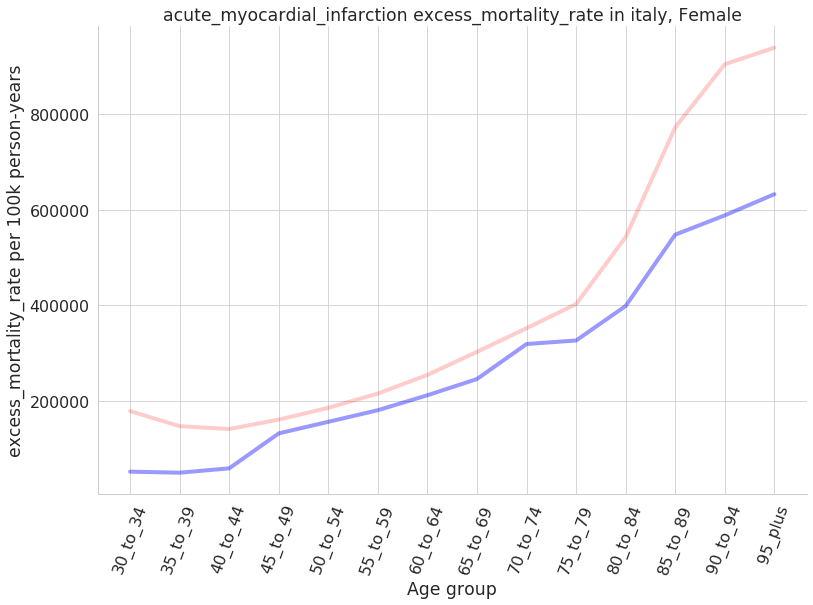

<Figure size 914.4x619.2 with 0 Axes>

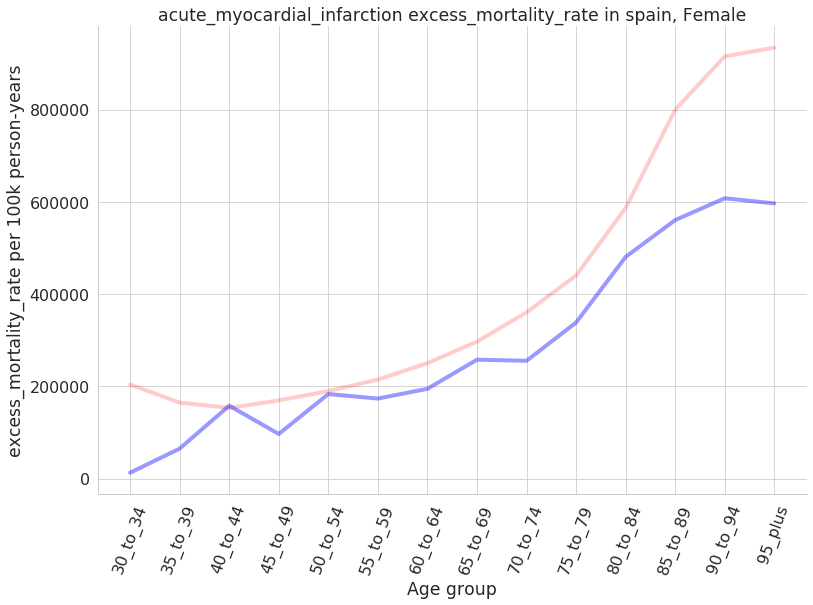

<Figure size 914.4x619.2 with 0 Axes>

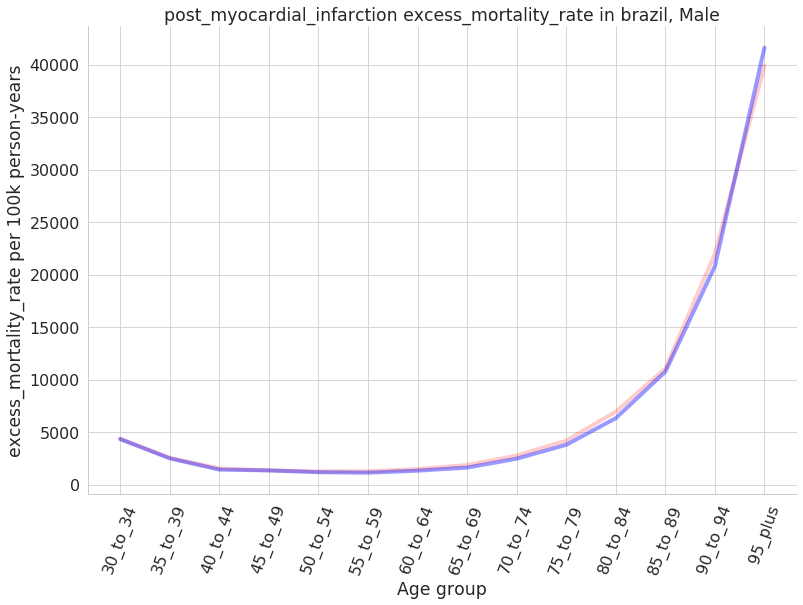

<Figure size 914.4x619.2 with 0 Axes>

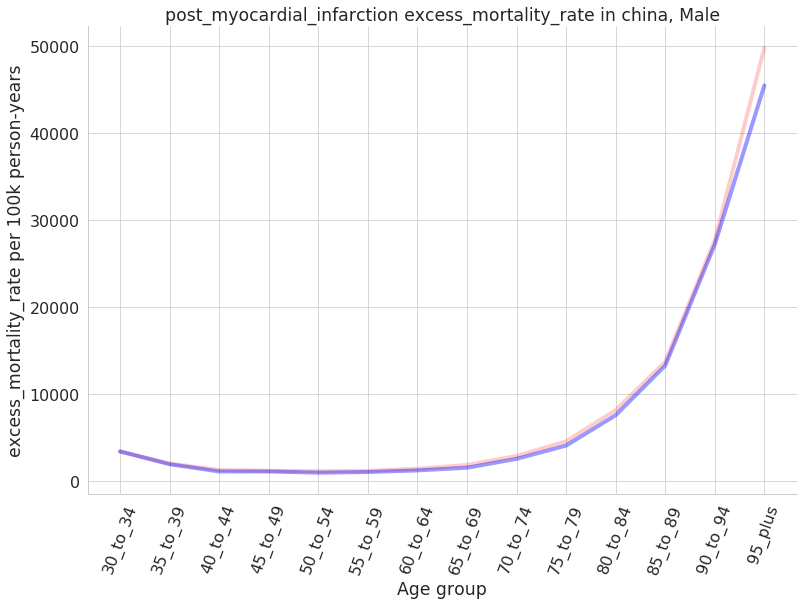

<Figure size 914.4x619.2 with 0 Axes>

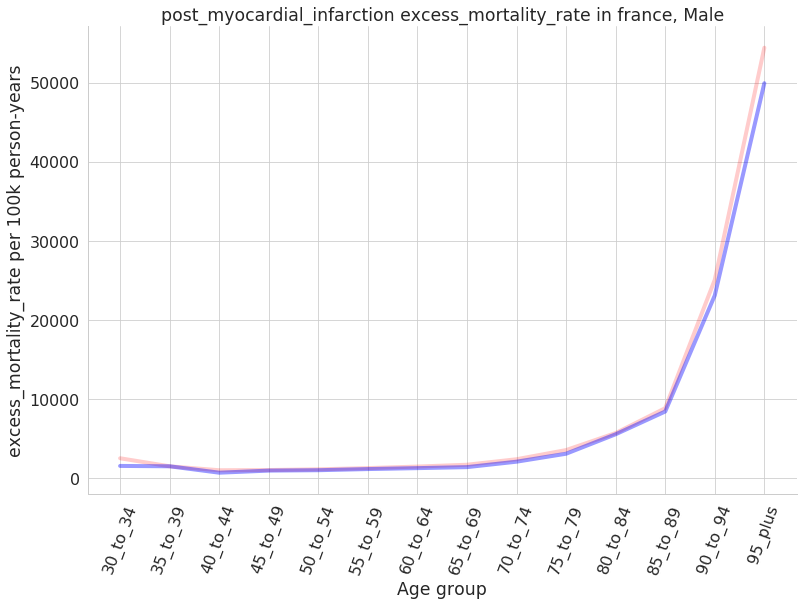

<Figure size 914.4x619.2 with 0 Axes>

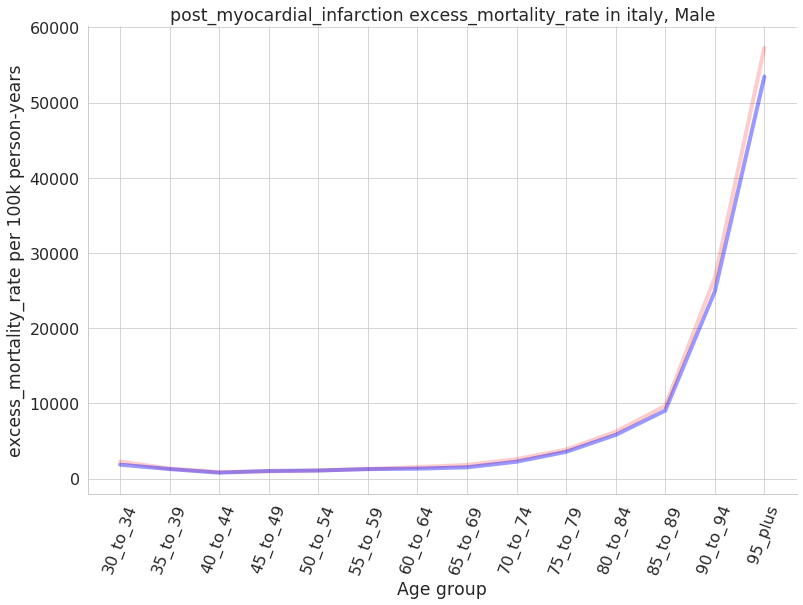

<Figure size 914.4x619.2 with 0 Axes>

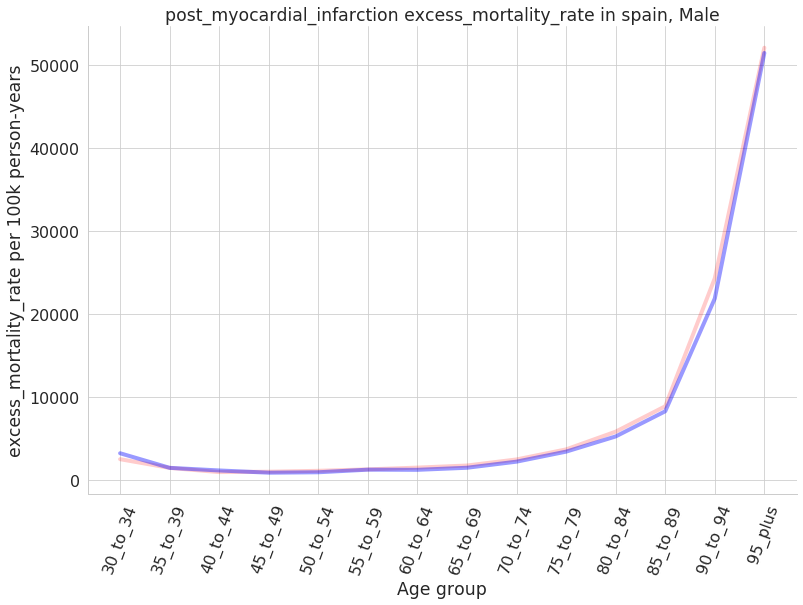

<Figure size 914.4x619.2 with 0 Axes>

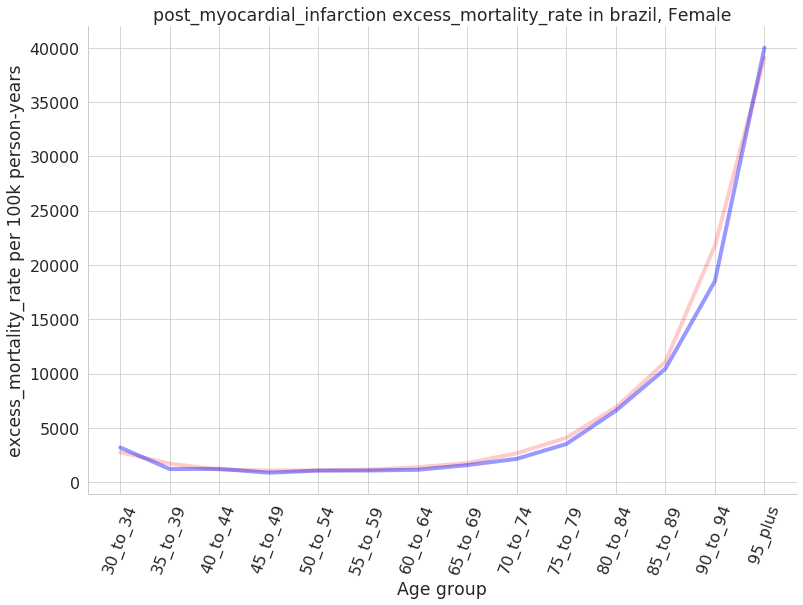

<Figure size 914.4x619.2 with 0 Axes>

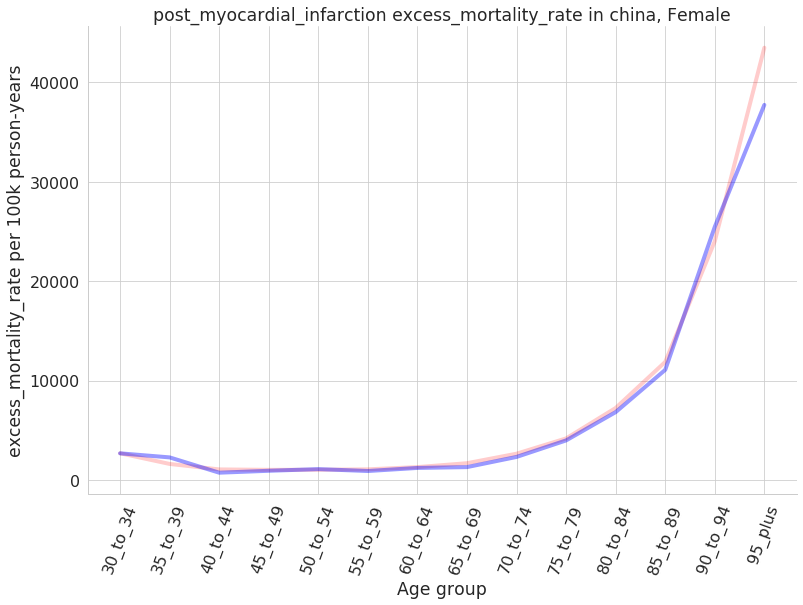

<Figure size 914.4x619.2 with 0 Axes>

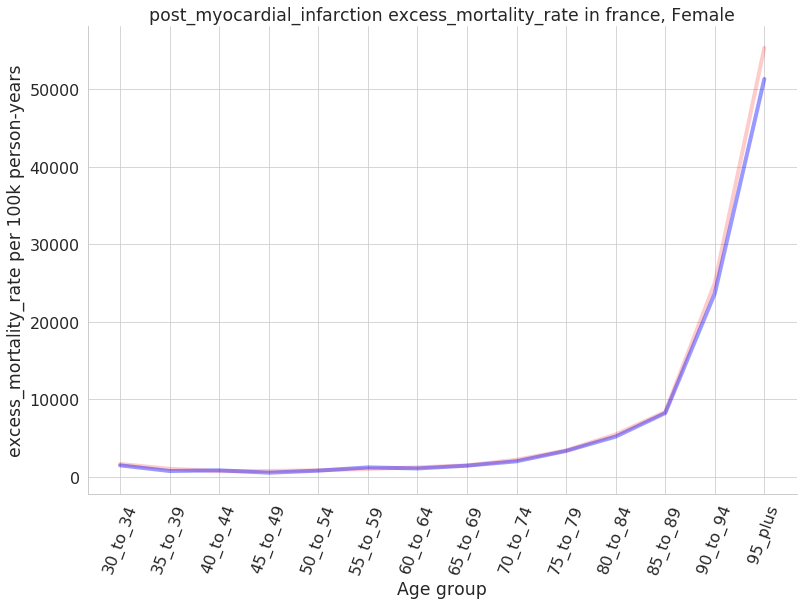

<Figure size 914.4x619.2 with 0 Axes>

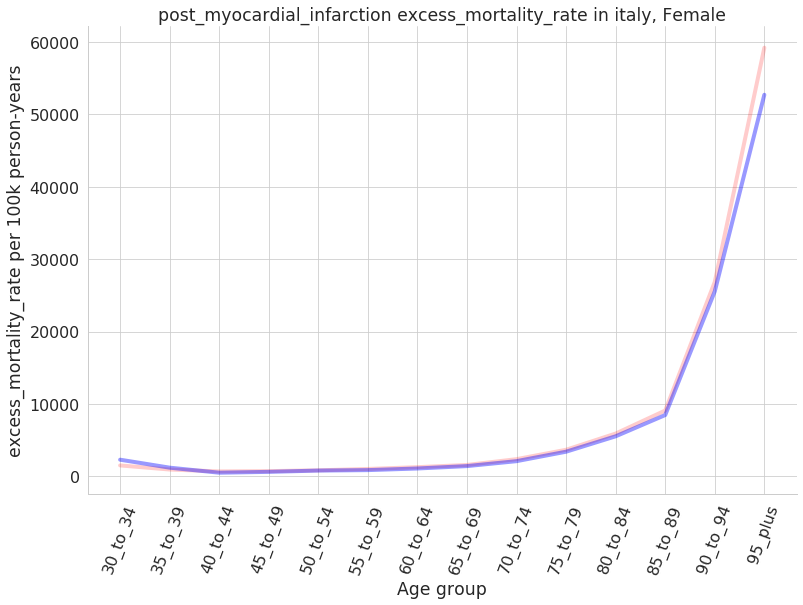

<Figure size 914.4x619.2 with 0 Axes>

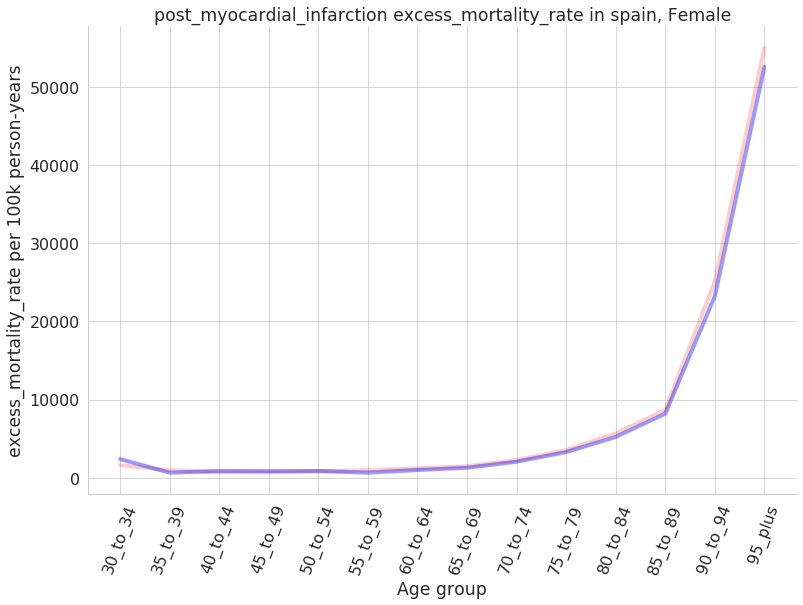

<Figure size 914.4x619.2 with 0 Axes>

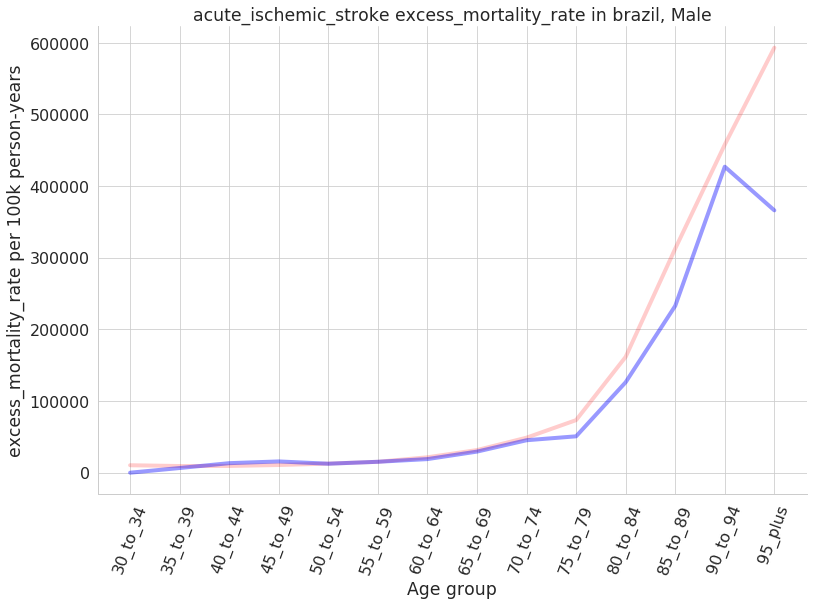

<Figure size 914.4x619.2 with 0 Axes>

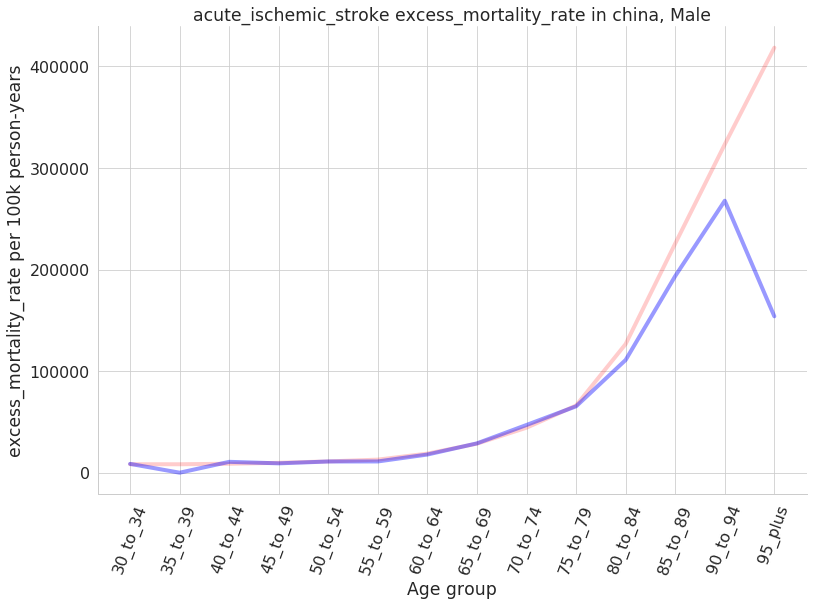

<Figure size 914.4x619.2 with 0 Axes>

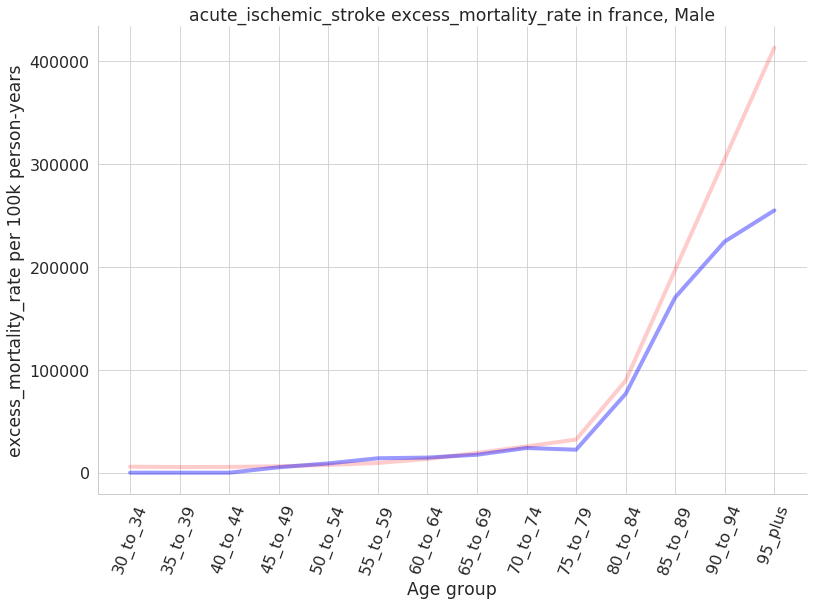

<Figure size 914.4x619.2 with 0 Axes>

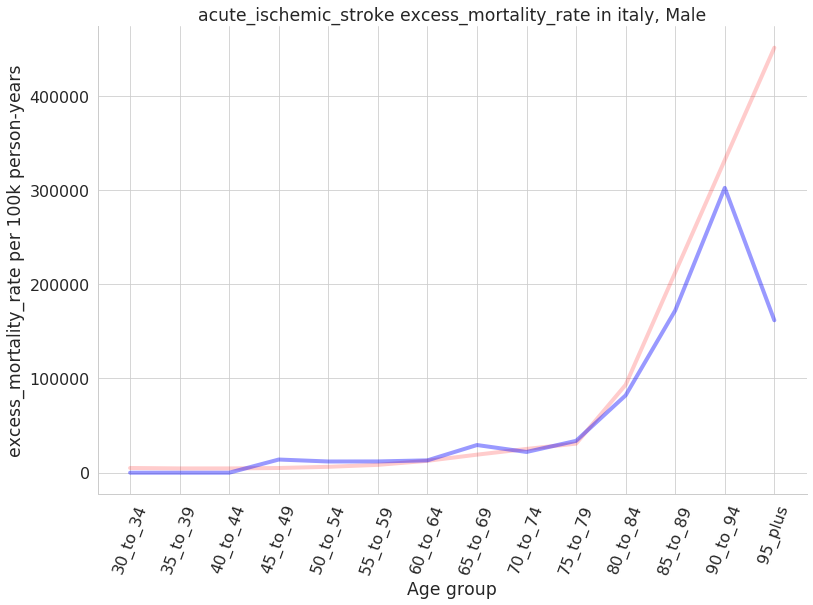

<Figure size 914.4x619.2 with 0 Axes>

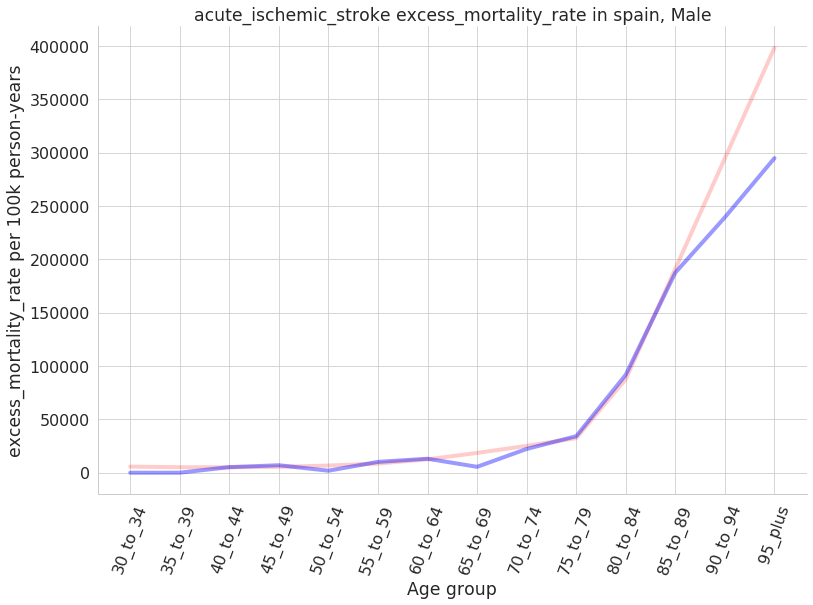

<Figure size 914.4x619.2 with 0 Axes>

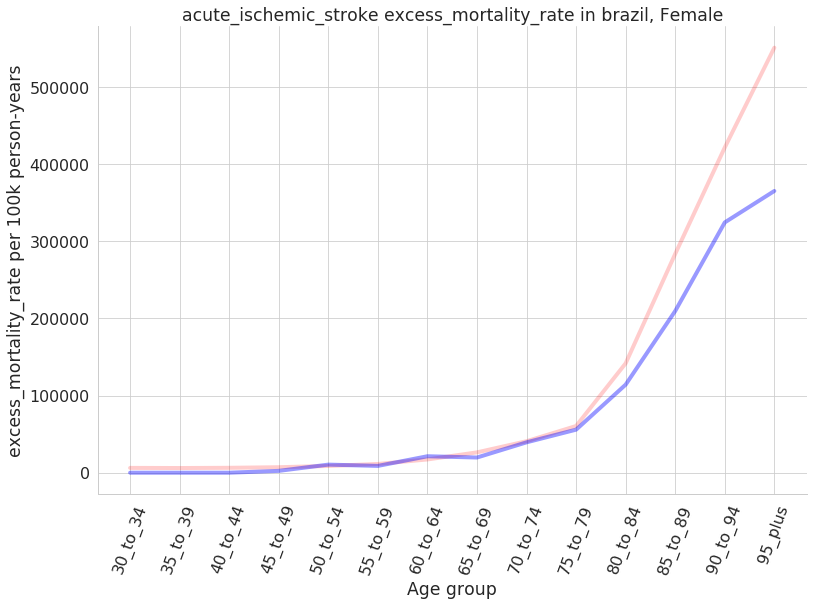

<Figure size 914.4x619.2 with 0 Axes>

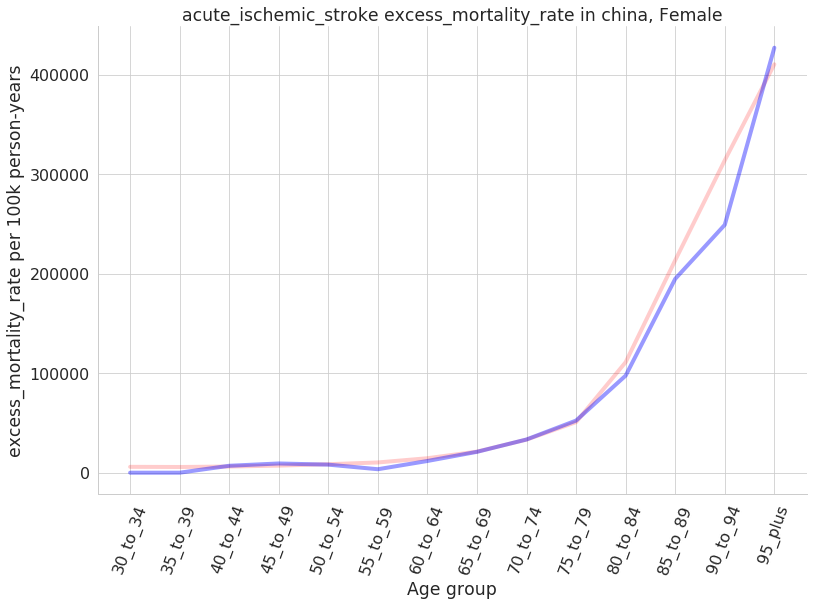

<Figure size 914.4x619.2 with 0 Axes>

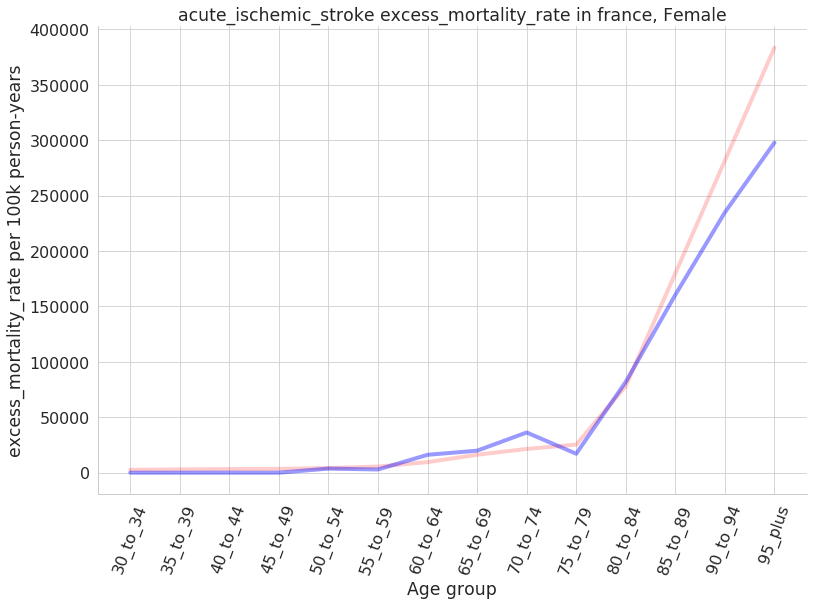

<Figure size 914.4x619.2 with 0 Axes>

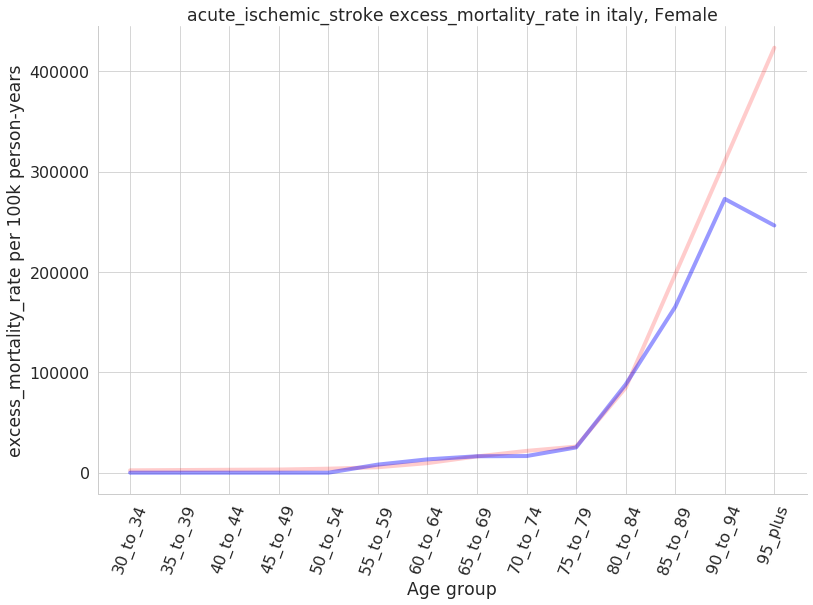

<Figure size 914.4x619.2 with 0 Axes>

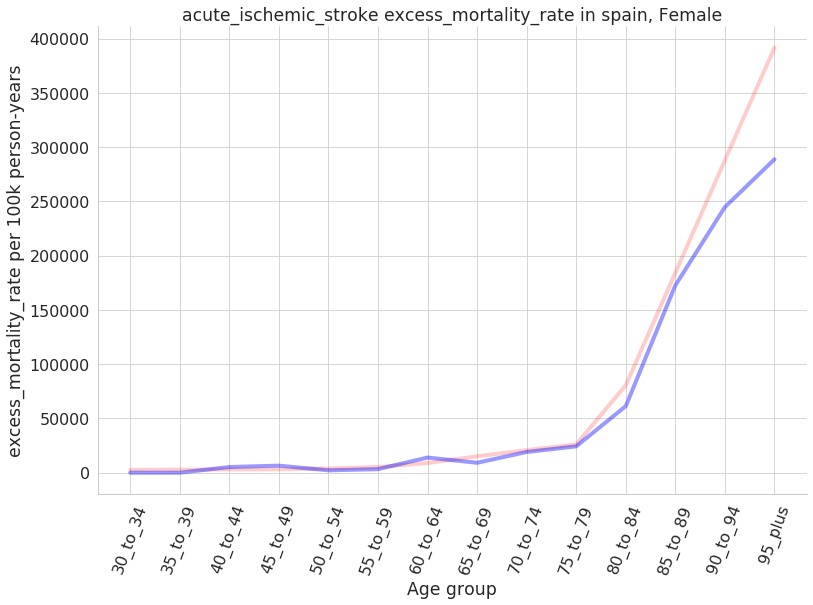

<Figure size 914.4x619.2 with 0 Axes>

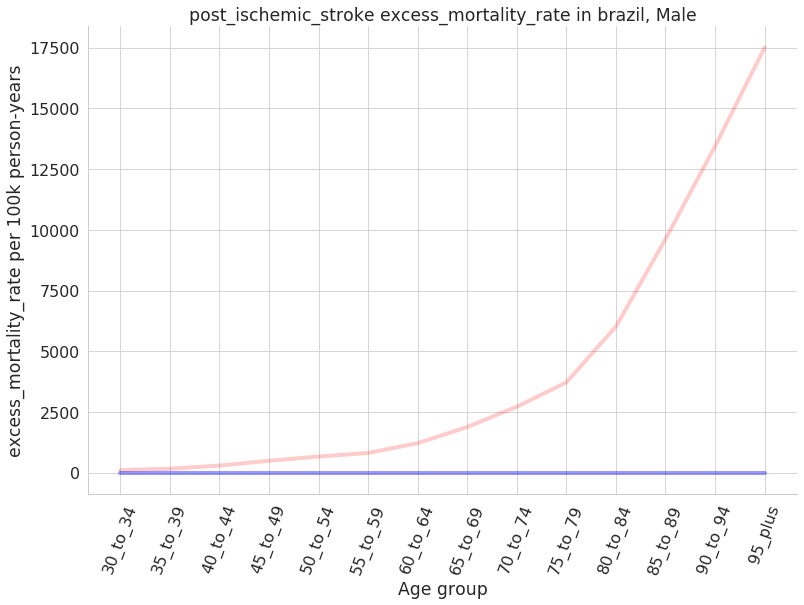

<Figure size 914.4x619.2 with 0 Axes>

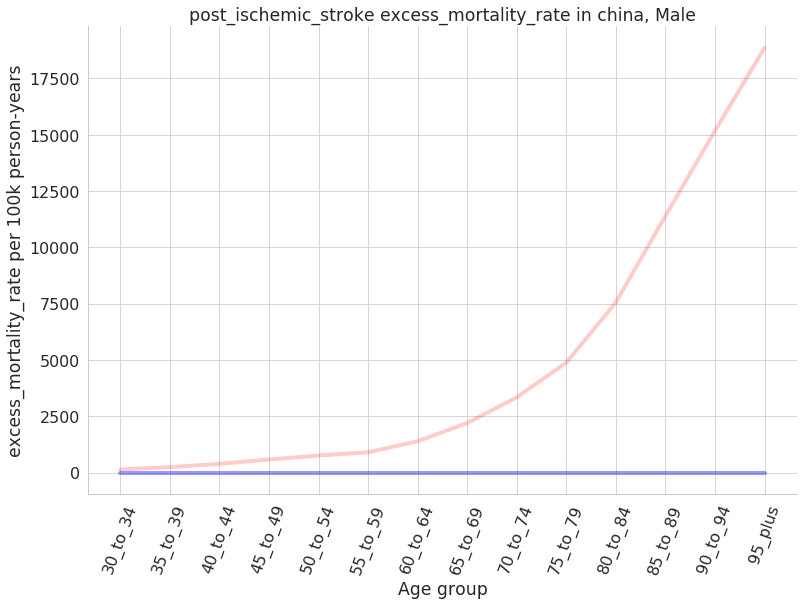

<Figure size 914.4x619.2 with 0 Axes>

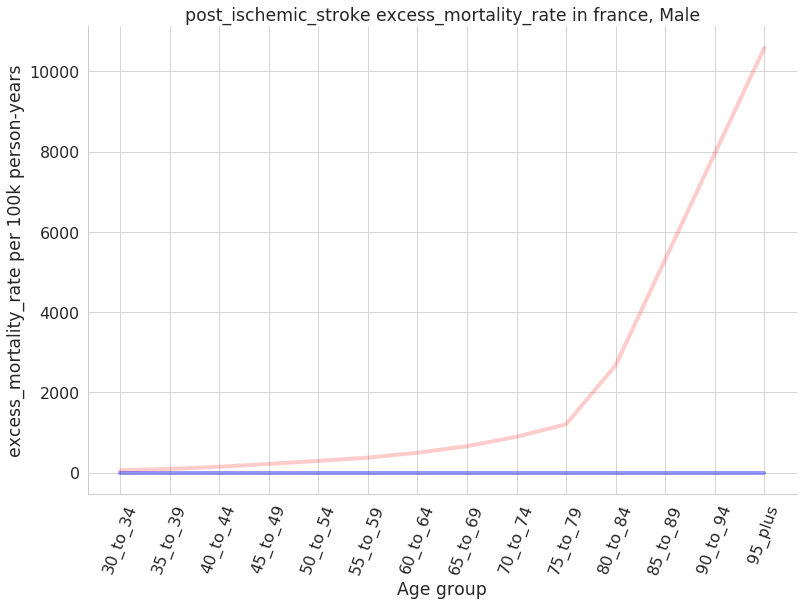

<Figure size 914.4x619.2 with 0 Axes>

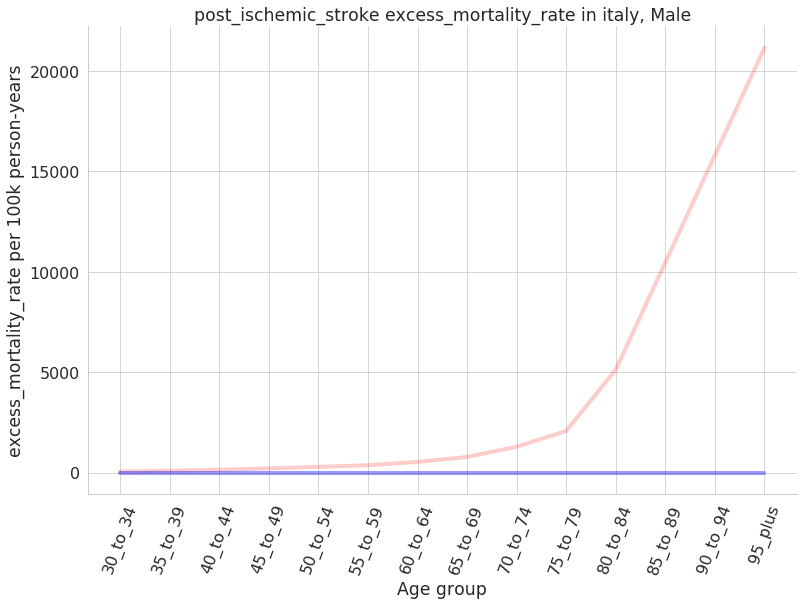

<Figure size 914.4x619.2 with 0 Axes>

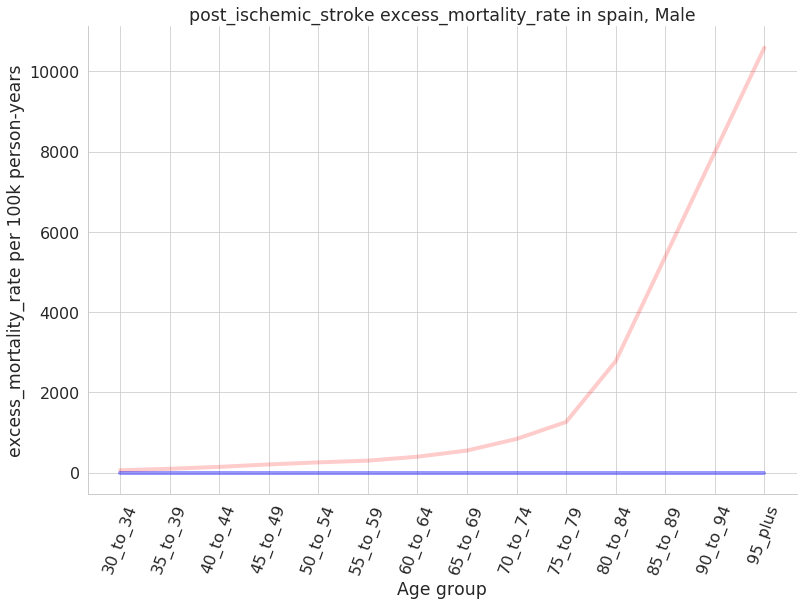

<Figure size 914.4x619.2 with 0 Axes>

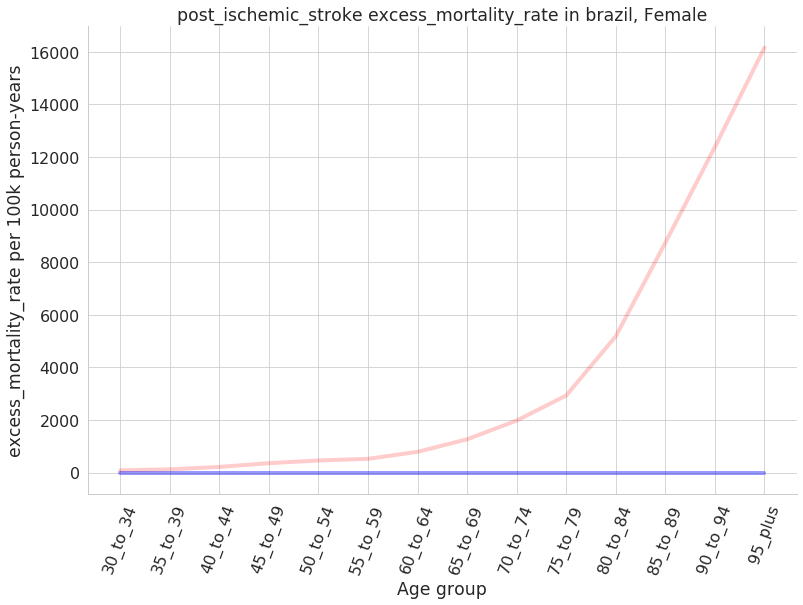

<Figure size 914.4x619.2 with 0 Axes>

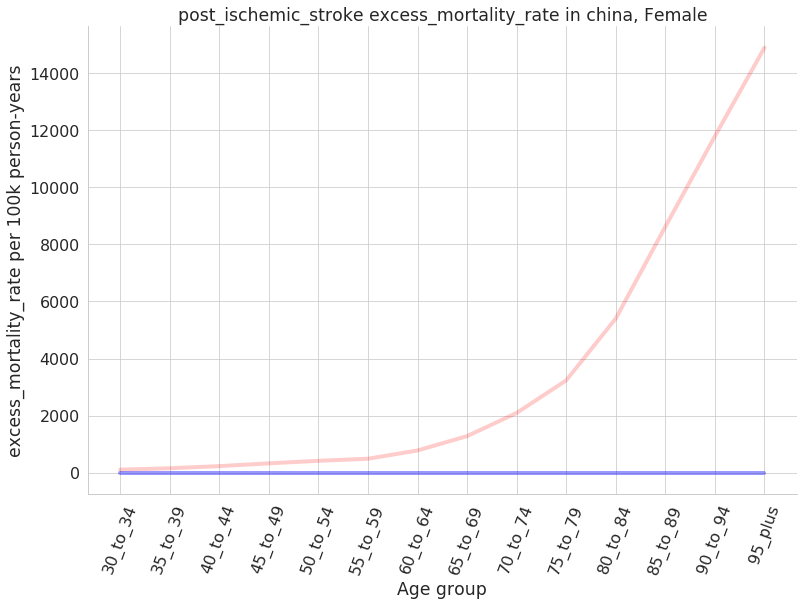

<Figure size 914.4x619.2 with 0 Axes>

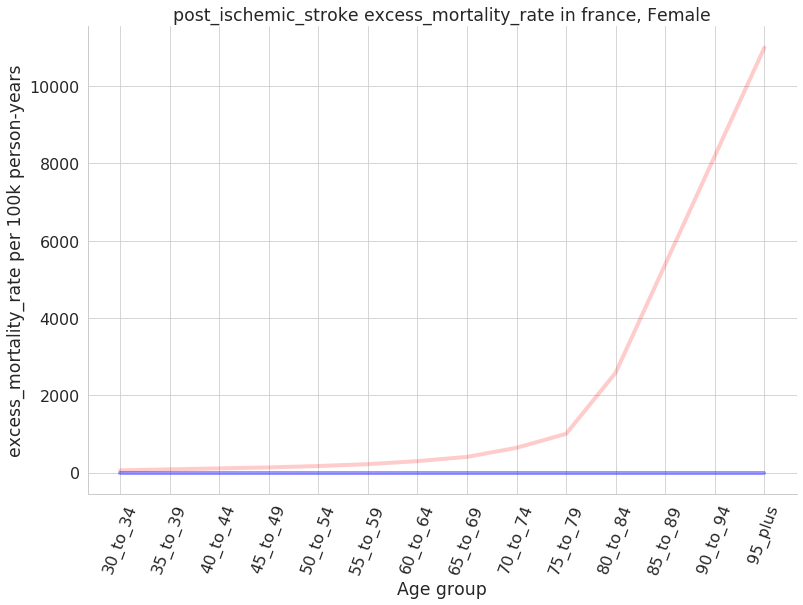

<Figure size 914.4x619.2 with 0 Axes>

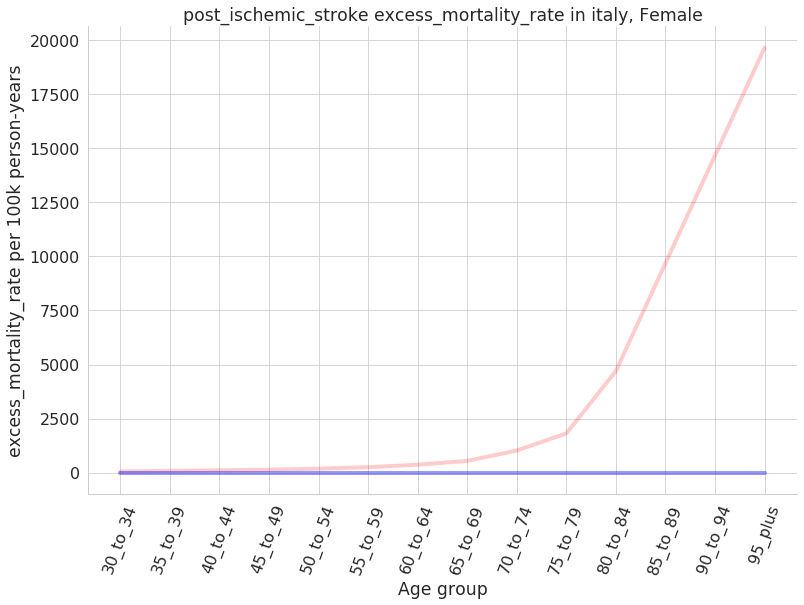

<Figure size 914.4x619.2 with 0 Axes>

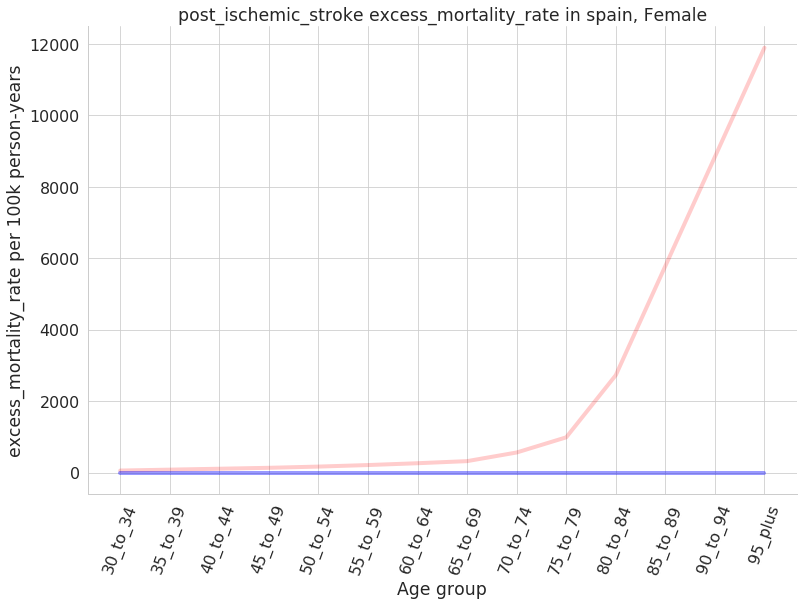

<Figure size 914.4x619.2 with 0 Axes>

In [101]:
plot_results_compare_artifact_model(artifact_emr, locations, emr)